# Cell clustering notebook

Note: this notebook should be run after `example_pixel_clustering.ipynb` in the same Docker session

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import numpy as np
import pandas as pd
import xarray as xr

from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

### Set file paths and parameters

Note: these should be the same as in `example_pixel_clustering.ipynb`

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from Segment_Image_Data.ipynb).
* `tiff_dir`: the path to the directory containing your imaging data
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb)

In [ ]:
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = "../data/granulomaCohort_allData"

* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments, taken from the consensus dir used in `example_pixel_clustering.ipynb`

In [ ]:
%store -r pixel_consensus_dir

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions.

In [ ]:
cell_table_name = 'cell_table_size_normalized.csv'

* `MIBItiff`: if the images in tiff_dir are mibitiff or not
* `mibitiff_suffix` (required if MIBItiff is True): the file suffix all mibitiff images contain

In [ ]:
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in tiff_dir
* Note: if setting a specific set of fovs, make sure it's the same as what was set in `example_pixel_clustering.ipynb`

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov14"]

### Train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_cell_clustered_name`: file to store cell data with just the SOM cluster assignments
* `{cluster_prefix}_cell_consensus_dir`: directory to store cell data with the SOM and consensus cluster assignments
* `{cluster_prefix}_cell_weights_name`: file name to place the cell SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = '%s_cell_mat_clustered.feather' % cluster_prefix
cell_consensus_name = '%s_cell_mat_consensus.feather' % cluster_prefix
cell_weights_name = '%s_cell_weights.feather' % cluster_prefix

* `cluster_col`: whether to use pixel SOM or meta cluster counts for training. Set to 'cluster' or 'hCluster_cap' respectively

In [ ]:
cluster_col = 'hCluster_cap'

For a full set of parameters you can customize for train_cell_som, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    base_dir,
    cell_table_name=cell_table_name,
    pixel_consensus_dir=pixel_consensus_dir,
    weights_name=cell_weights_name,
    cluster_col=cluster_col,
    num_passes=10
)

### Assign cell SOM clusters

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name
)

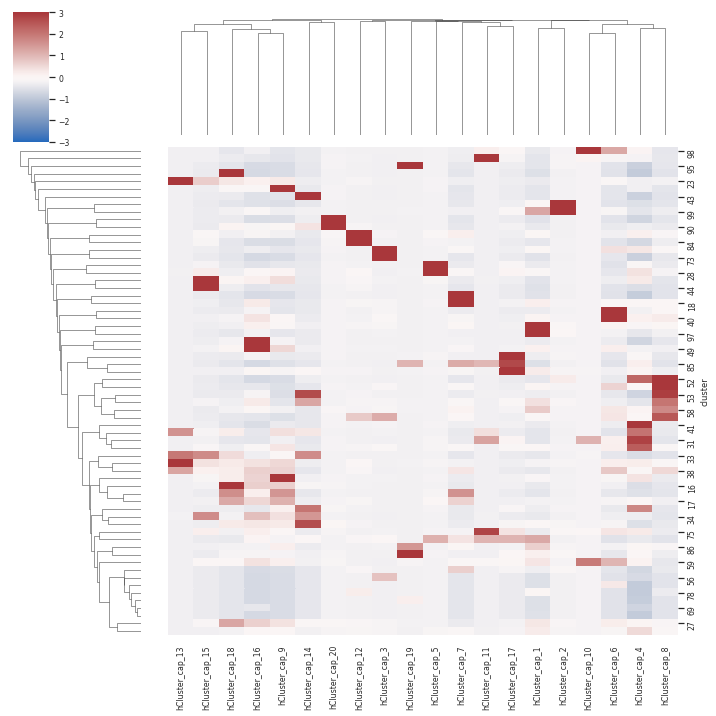

In [12]:
# visualize the cell SOM cluster average heatmap
som_utils.visualize_avg_p2c_counts(
    base_dir,
    cluster_name=cell_clustered_name,
    column_prefix=cluster_col,
    cell_cluster_col='cluster',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Run cell consensus clustering

For a full set of parameters you can customize for cell_consensus_cluster, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster

In [ ]:
# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    base_dir=base_dir,
    cell_cluster_name=cell_clustered_name,
    column_prefix=cluster_col,
    cell_consensus_name=cell_consensus_name
)

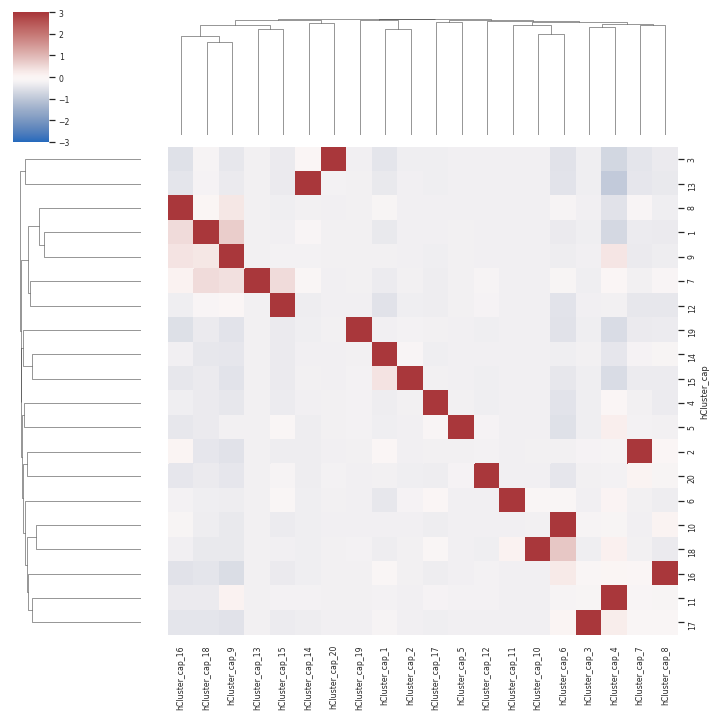

In [14]:
# visualize the cell hierarchical cluster average heatmap
som_utils.visualize_avg_p2c_counts(
    base_dir,
    cluster_name=cell_consensus_name,
    column_prefix=cluster_col,
    cell_cluster_col='hCluster_cap',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Visualize cell cluster overlay

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cluster_col='hCluster_cap'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        base_dir,
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

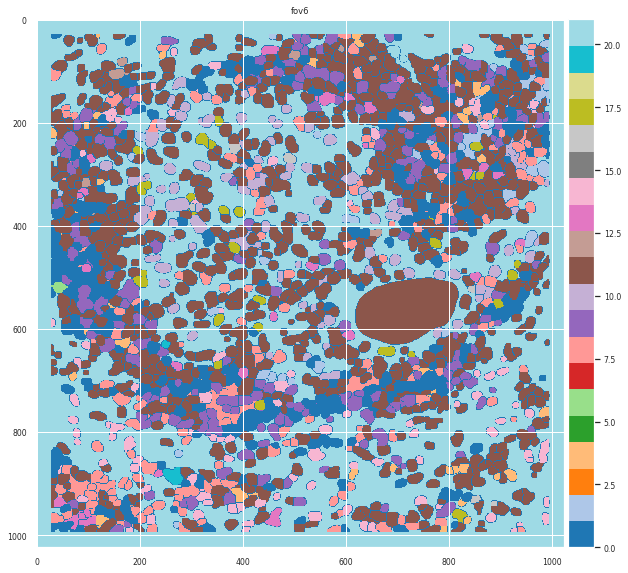

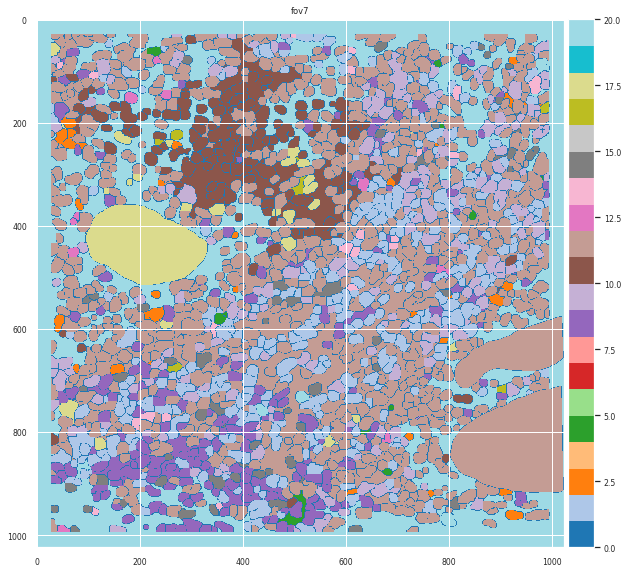

In [18]:
plot_utils.plot_clustering_result(
    cell_cluster_masks,
    cell_fovs
)

### Compute channel average per cell (weighted by pixel SOM/meta clusters per cell)

* This will be used for interactive reclustering later
* Results are saved as `cell_channel_avg.feather` in `base_dir`

In [ ]:
# note: this file will have been created by example_pixel_clustering.ipynb
pixel_cluster_avg = feather.read_dataframe(os.path.join(base_dir, 'pixel_cluster_avg.feather'))

In [ ]:
# compute number of pixel SOM/meta clusters per cell
pixel_cluster_counts_per_cell = som_utils.compute_cell_cluster_counts(
    fovs, os.path.join(base_dir, pixel_consensus_dir), os.path.join(base_dir, cell_table_name), cluster_col=cluster_col
)

In [ ]:
# compute the weighted channel average per cell
cell_channel_avg = som_utils.compute_cell_cluster_channel_avg(
    pixel_cluster_avg, pixel_cluster_counts_per_cell, fovs=fovs, cluster_col=cluster_col
)

In [ ]:
# save cell_channel_avg
feather.write_dataframe(
    cell_channel_avg, os.path.join(base_dir, 'cell_channel_avg.feather')
)